# e-Commerce (Target) Sales Dataset Analysis and Visualization

### Importing the csv dataset to MySQL Workbench

In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Swarup@2003',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:\ECommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Swarup@2003",
                             database = "ecommerce")

cur = db.cursor()


### All unique cities where customers are located.


In [24]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["City name"])
df

,City name
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### Number of orders placed in 2017

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

### Total sales per Category.

In [4]:
query = """ select products.product_category category, round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


### Percentage of orders that were paid in installments.

In [4]:
query = """ select sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments; """
cur.execute(query)
data = cur.fetchall()
"Percentage =", data[0]

('Percentage =', (Decimal('99.9981'),))

### Number of Customers from each state

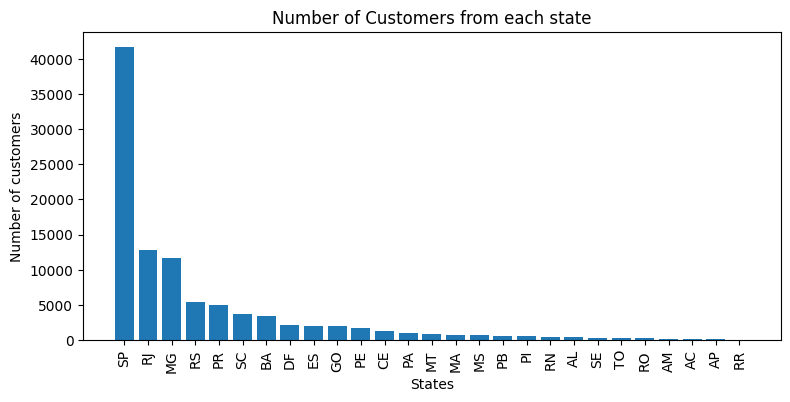

In [24]:
query = """ select customer_state, count(customer_id) 
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State", "Number of customers"])
df = df.sort_values(by = "Number of customers", ascending=False)

plt.figure(figsize=(9,4))
plt.bar(df["State"], df["Number of customers"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Number of customers")
plt.title("Number of Customers from each state")
plt.show()

### Number of orders per month in 2018

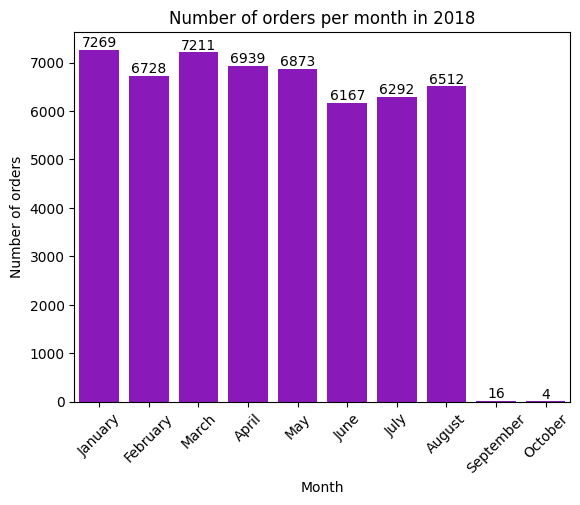

In [37]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Month", "Number of orders"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x = df['Month'], y = df['Number of orders'], data = df, order = o, color = "darkviolet")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show()


### Average number of products per order, grouped by customer city

In [48]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc), 2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer city", "Average number products per order"])
df

,Customer city,Average number products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


### Percentage of total revenue contributed by each product category

In [51]:
query = """ select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments)) * 100, 2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Categpry", "Percentage of revenue"])
df

,Categpry,Percentage of revenue
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


### Correlation between product price and the number of times a product has been purchased

In [58]:
query = """ select products.product_category, count(order_items.product_id), round(avg(order_items.price), 2) 
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Product Category", 'Total number of products bought', 'Average price'])

arr1 = df['Total number of products bought']
arr2 = df['Average price']
a = np.corrcoef([arr1, arr2])
print("Correlation between price and number of times a product has been purchased is ", a)

Correlation between price and number of times a product has been purchased is  [[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


### Total revenue generated by each seller

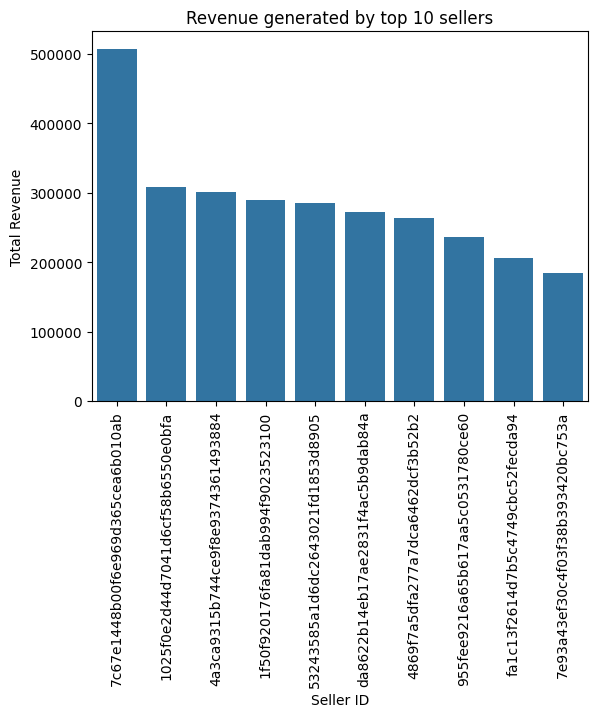

In [75]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from  
(select order_items.seller_id, round(sum(payments.payment_value), 2) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller ID", "Total Revenue", "rank"])
df = df.head(10)

sns.barplot(x = 'Seller ID', y = "Total Revenue", data = df)
plt.title("Revenue generated by top 10 sellers")
plt.xticks(rotation = 90)
plt.show()


### Moving Average of order values for each customer over their order history


In [83]:
query = """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg 
from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer ID", "Order placed date", "Price", "Moving average"])
df

,Customer ID,Order placed date,Price,Moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### Cumulative sales per month for each year

In [82]:
query = """ select years, months, payment,sum(payment) 
over(order by years, months) as cumulative_sales from
(SELECT year(orders.order_purchase_timestamp) as years, month(order_purchase_timestamp) as months, 
round(sum(payments.payment_value), 2) as payment from orders join payments 
on orders.order_id = payments.order_id 
group by years, months order by years, months) as a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "Month", "Payment", "Cumulative sales"])
df

,Year,Month,Payment,Cumulative sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14
